# 0 - Import packages:

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
from sklearn.model_selection import StratifiedKFold
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# 1 - Load data:

## 1.1 - Train set: 

In [95]:
df_data_1 = pd.read_csv("../common/albertom/train_test_val_split/X_train.csv", index_col="Unnamed: 0")
# df_data_1 = df_data_1.head(500)
print(df_data_1.shape)
df_data_1.head()

(19423, 87)


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,12.779214,2.016426,2.284677,0.390674,0.390674,0.390674,0.390674,6.768347,6.680881,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.833644,16.668139,16.808813,16.654894,16.755709,16.843528,14.402775,6.201567,0.000000,6.015140,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.634856,8.497548,8.639800,8.977254,9.014708,9.051246,9.118075,3.700733,4.616464,3.100784,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.416822,5.882313,6.138657,6.594265,6.749420,6.649788,6.580524,3.295074,3.906743,3.100784,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.718844,11.035281,6.411440,3.443018,5.610607,3.743060,3.788609,6.411440,5.828984,5.610607,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.2 - Train labels:

In [96]:
df_target_data_1 = pd.read_csv("../common/albertom/train_test_val_split/y_train.csv", index_col="Unnamed: 0")
# df_target_data_1 = df_target_data_1.head(500)
print(df_target_data_1.shape)
df_target_data_1.head()

(19423, 2)


,0,1
0,0,18329863
1,1,51718313
2,1,32674991
3,1,46137138
4,0,15314372


## 1.3 - Test set:

In [97]:
df_data_2 = pd.read_csv("../common/albertom/train_test_val_split/X_test.csv", index_col="Unnamed: 0")
# df_data_2 = df_data_2.head(100)
print(df_data_2.shape)
df_data_2.head()

(4033, 87)


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,9.634856,7.659067,8.051780,8.114748,8.146468,8.081561,8.164696,4.472104,3.100784,2.878513,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.177282,17.488188,10.715162,8.502775,8.348941,5.372040,0.000000,0.000000,3.906743,3.235422,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.360872,13.159441,13.101860,12.024029,12.086121,12.136122,11.940344,5.631366,4.208411,4.472104,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.833644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.475372,2.322137,0.000000,3.680303,2.381428,3.988994,3.480337,0.000000,3.680303,2.381428,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.4 - Test labels:

In [98]:
df_target_data_2 = pd.read_csv("../common/albertom/train_test_val_split/y_test.csv", index_col="Unnamed: 0")
# df_target_data_2 = df_target_data_2.head(100)
print(df_target_data_2.shape)
df_target_data_2.head()

(4033, 2)


,0,1
0,1,10930294
1,1,55016784
2,0,48129536
3,1,37805023
4,0,22798417


## 1.5 - Val set:

In [99]:
df_data_3 = pd.read_csv("../common/albertom/train_test_val_split/X_val.csv", index_col="Unnamed: 0")
# df_data_3 = df_data_3.head(100)
print(df_data_3.shape)
df_data_3.head()

(3428, 87)


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,9.634856,8.382878,8.413033,8.696147,9.017886,9.252007,9.361804,4.472104,4.707903,4.472104,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17.507695,1.476656,1.574811,2.540538,1.434443,0.000000,0.000000,1.574811,2.540538,1.434443,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.139158,11.879250,11.923661,12.013227,12.045026,11.744630,11.857166,4.000204,5.208719,3.857953,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.360872,4.122501,4.122501,5.194026,4.122501,4.122501,4.122501,4.122501,5.194026,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.360872,4.332114,3.685432,2.564938,12.250356,12.022104,12.022104,3.685432,2.564938,12.250356,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.6 - Val labels:

In [100]:
df_target_data_3 = pd.read_csv("../common/albertom/train_test_val_split/y_val.csv", index_col="Unnamed: 0")
# df_target_data_3 = df_target_data_3.head(100)
print(df_target_data_3.shape)
df_target_data_3.head()

(3428, 2)


,0,1
0,0,37382735
1,0,16291467
2,0,16215767
3,0,39563885
4,0,50610721


# 2 - Globals:

## 2.1 - Parameters 

In [123]:
num_steps = 10001
k_p = 0.9

valid_size = df_data_3.shape[0]
test_size = df_data_2.shape[0]
batch_size = 128

distinct_labels = len(df_target_data_1["0"].unique())

train_dataset = df_data_1.values
val_dataset = df_data_3.values
test_dataset = df_data_2.values

split_labels = df_target_data_1["0"].values
train_labels = (np.arange(distinct_labels) == split_labels[:,None]).astype(np.float32)

test_labels = df_target_data_2["0"].values
test_labels = (np.arange(distinct_labels) == test_labels[:,None]).astype(np.float32)

val_labels = df_target_data_3["0"].values
val_labels = (np.arange(distinct_labels) == val_labels[:,None]).astype(np.float32)

num_features = train_dataset.shape[1]
num_examples = train_dataset.shape[0]

## 2.2 - Tensorflow graph: 

In [124]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    X = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    t = tf.placeholder(tf.int32, shape=(batch_size, distinct_labels))

    L2_reg = tf.placeholder(tf.float32, shape=[])
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    keep_prob = tf.constant(k_p, tf.float32)
    
    X_val = tf.constant(val_dataset, tf.float32)
    X_test = tf.constant(test_dataset, tf.float32)

    # Variables.
    num_hidden1 = 30
    num_hidden2 = 30
    num_hidden3 = 30
    num_hidden4 = 30
    #num_hidden5 = 30
    #num_hidden6 = 15
    
    global_step = tf.Variable(0)
    
    W1 = tf.Variable(tf.truncated_normal([num_features, num_hidden1]) )
    b1 = tf.Variable(tf.zeros([num_hidden1]))

    W2 = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2]))
    b2 = tf.Variable(tf.zeros([num_hidden2]))
    
    W3 = tf.Variable(tf.truncated_normal([num_hidden2, num_hidden3]))
    b3 = tf.Variable(tf.zeros([num_hidden3]))
    
    W4 = tf.Variable(tf.truncated_normal([num_hidden3, num_hidden4]))
    b4 = tf.Variable(tf.zeros([num_hidden4]))
    
    W5 = tf.Variable(tf.truncated_normal([num_hidden4, distinct_labels]))
    b5 = tf.Variable(tf.zeros([distinct_labels]))
    
    #W6 = tf.Variable(tf.truncated_normal([num_hidden5, num_hidden6]))
    #b6 = tf.Variable(tf.zeros([num_hidden6]))
    
    #W7 = tf.Variable(tf.truncated_normal([num_hidden6, distinct_labels]))
    #b7 = tf.Variable(tf.zeros([distinct_labels]))
    
    # Training.
    H1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    #H1_dropout = tf.nn.dropout(H1, keep_prob)
    H2 = tf.nn.relu(tf.matmul(H1, W2) + b2)
    #H2_dropout = tf.nn.dropout(H2, keep_prob)
    H3 = tf.nn.relu(tf.matmul(H2, W3) + b3)
    #H3_dropout = tf.nn.dropout(H3, keep_prob)
    H4 = tf.nn.relu(tf.matmul(H3, W4) + b4)
    #H4_dropout = tf.nn.dropout(H4, keep_prob)
    #H5 = tf.nn.relu(tf.matmul(H4, W5) + b5)
    #H5_dropout = tf.nn.dropout(H5, keep_prob)
    #H6 = tf.nn.relu(tf.matmul(H5, W6) + b6)
    #H6_dropout = tf.nn.dropout(H6, keep_prob)
    logits = tf.matmul(H4, W5) + b5
    
    # Loss NO reg.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, t))
    regularization = (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + 
                      tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) + 
                      tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) +  
                      tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4) + 
                      tf.nn.l2_loss(W5) + tf.nn.l2_loss(b5))
    
    loss = loss + L2_reg * regularization

    # Optimizer.
    l_r = tf.train.exponential_decay(learning_rate, global_step, 100000, 0.95, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=l_r).minimize(loss)

    # Predictions for training, validation.
    train_predictions = tf.nn.softmax(logits)
    
    H1_val = tf.nn.relu(tf.matmul(X_val, W1) + b1)
    H2_val = tf.nn.relu(tf.matmul(H1_val, W2) + b2)
    H3_val = tf.nn.relu(tf.matmul(H2_val, W3) + b3)
    H4_val = tf.nn.relu(tf.matmul(H3_val, W4) + b4)
    #H5_val = tf.nn.relu(tf.matmul(H4_val, W5) + b5)
    #H6_val = tf.nn.relu(tf.matmul(H5_val, W6) + b6)
    logits_val = tf.matmul(H4_val, W5) + b5
    
    val_predictions = tf.nn.softmax(logits_val)
    
    H1_test = tf.nn.relu(tf.matmul(X_test, W1) + b1)
    H2_test = tf.nn.relu(tf.matmul(H1_test, W2) + b2)
    H3_test = tf.nn.relu(tf.matmul(H2_test, W3) + b3)
    H4_test = tf.nn.relu(tf.matmul(H3_test, W4) + b4)
    #H5_test = tf.nn.relu(tf.matmul(H4_test, W5) + b5)
    #H6_test = tf.nn.relu(tf.matmul(H5_test, W6) + b6)
    logits_test = tf.matmul(H4_test, W5) + b5
    
    test_predictions = tf.nn.softmax(logits_test)
    

## 2.3 - Functions:

In [103]:
# Given a set of model parameters (learning rate, regularization penalty coefficient), find the optimal parameters with cross validation

def holdout_validation(set_of_learning_rates, set_of_regs, X_train, y_train):
    
    # Get train-validation set stratified (keeps the same distribution) splitter
    #skf = StratifiedKFold(n_splits=3)
    set_of_params = [(x,y) for x in set_of_learning_rates for y in set_of_regs]
    
    #print("Number of folds: " + str(n_folds))
    print("Number of parameters combinations: " + str(len(set_of_params)))
    print("We will train " + str(len(set_of_params)) + " neural networks for this validation task.")
    
    f1 = np.zeros(len(set_of_params))

    t1= time.time()
    for param_idx, param in enumerate(set_of_params):

        print(str(param_idx) + ") Combination: [Parameters: " +  str(param) + " | Train model]")
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
                
            for step in np.arange(num_steps):

                offset = (step * batch_size) % (num_examples - batch_size)
                X_batch = X_train[offset:(offset + batch_size), :]
                t_batch = y_train[offset:(offset + batch_size)]
                feed_dict = {
                    X : X_batch,
                    t : t_batch,
                    L2_reg : param[1],
                    learning_rate : param[0]
                }
                _, l, pred_batch = session.run( [optimizer, loss, train_predictions], feed_dict=feed_dict)
                
                #if (step % 500 == 0):
                #    print("> Minibatch loss at step %d: %f" % (step, l))
                #    print("> Training f1: %f%%" % score(pred_batch, t_batch))
                #    print("> Validation f1: %f%%" % score(val_predictions.eval(), val_labels))
                
            f1_cv = score(val_predictions.eval(), val_labels)
            print("|> Final Validation f1: %.1f%%" % f1_cv)
            f1[param_idx] = f1[param_idx] + f1_cv
    
    print('>>>>>> Gridsearch done in '+ str(round((time.time()-t1)/60, 0)) + ' min')
    print(">>>>>> Best [learning rate - f1] = ", set_of_params[np.argmax(f1)][1])
    print(">>>>>> BEST [reg - f1] = ", set_of_params[np.argmax(f1)][0])
    print(">>>>>> SELECTED VALIDATION f1: %f%%" % np.max(f1))
    print(">>>>>> THE SET OF F1 PER COMBINATION IS: " + str(f1))
    return set_of_params[np.argmax(f1)]

In [104]:
def score(predictions, labels):
    return 100*f1_score(np.argmax(labels, 1), np.argmax(predictions, 1))

In [105]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [106]:
def plot_results(predictions, reals):

    predicted_classes = np.argmax(predictions, 1)
    real_classes = np.argmax(reals, 1)
    
    print(predicted_classes)
    print(real_classes)
    
    # Plot the results
    plt.scatter(np.arange(0, len(predicted_classes)), predicted_classes, color='b')
    plt.scatter(np.arange(0, len(real_classes)), real_classes, color='r')

    lines = []
    ax = plt.axes()

    for i in range(predicted_classes.shape[0]):
        lines.append([(i, predicted_classes[i]), (i, real_classes[i])])

    lc = mc.LineCollection(lines, colors="g", linewidths=0.1)

    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.grid(True)

    plt.show()

# 3 - Training: 

## 3.1 - Holdout for optimal hyperparameters:

 - [0.0001, 0.0001] 30 30 30 30 no_dropout 128 batch size 7001 iterations -> 36,2%
 - [0.0001, 0.0012] 30 30 30 30 no_dropout 128 batch size 7001 iterations -> 38,9%

In [125]:
set_of_learning_rates = np.arange(0.0001, 0.0002, step=0.0001)
set_of_L2_regs = np.arange(0.001, 0.002, step=0.0001)

print("Holdout validation on TRAINING-SET for [learning rate, L2_reg] ...")

best_params = holdout_validation(set_of_learning_rates, set_of_L2_regs, train_dataset, train_labels)

best_learning_rate = best_params[0]
best_L2_reg = best_params[1]

print("Best parameters: [" + str(best_learning_rate) + ", " + str(best_L2_reg) + "] ...")

Holdout validation on TRAINING-SET for [learning rate, L2_reg] ...
Number of parameters combinations: 10
We will train 10 neural networks for this validation task.
0) Combination: [Parameters: (0.0001, 0.001) | Train model]
|> Final Validation f1: 17.7%
1) Combination: [Parameters: (0.0001, 0.0011000000000000001) | Train model]
|> Final Validation f1: 3.5%
2) Combination: [Parameters: (0.0001, 0.0012000000000000001) | Train model]
|> Final Validation f1: 7.8%
3) Combination: [Parameters: (0.0001, 0.0013000000000000002) | Train model]
|> Final Validation f1: 6.5%
4) Combination: [Parameters: (0.0001, 0.0014000000000000002) | Train model]
|> Final Validation f1: 6.6%
5) Combination: [Parameters: (0.0001, 0.0015000000000000002) | Train model]
|> Final Validation f1: 12.8%
6) Combination: [Parameters: (0.0001, 0.0016000000000000003) | Train model]
|> Final Validation f1: 33.9%
7) Combination: [Parameters: (0.0001, 0.0017000000000000003) | Train model]
|> Final Validation f1: 41.0%
8) Combi

## 3.2 - Prediction using optimal hyperparameters:

Prediction for TEST-SET using best parameters ...
Combination: [Parameters: 0.0001, 0.0019 | Train model]
> Minibatch loss at step 0: 857.441406
> Training f1: 40.9%
> Validation f1: 19.6%
> Minibatch loss at step 500: 16.346371
> Training f1: 50.0%
> Validation f1: 28.1%
> Minibatch loss at step 1000: 9.537144
> Training f1: 42.6%
> Validation f1: 25.1%
> Minibatch loss at step 1500: 11.200073
> Training f1: 37.9%
> Validation f1: 37.1%
> Minibatch loss at step 2000: 12.663333
> Training f1: 13.0%
> Validation f1: 36.3%
> Minibatch loss at step 2500: 9.826274
> Training f1: 41.1%
> Validation f1: 23.7%
> Minibatch loss at step 3000: 8.992987
> Training f1: 43.1%
> Validation f1: 35.7%
> Minibatch loss at step 3500: 8.020615
> Training f1: 27.7%
> Validation f1: 18.6%
> Minibatch loss at step 4000: 14.079302
> Training f1: 6.5%
> Validation f1: 26.2%
> Minibatch loss at step 4500: 6.564208
> Training f1: 37.9%
> Validation f1: 39.2%
> Minibatch loss at step 5000: 6.837103
> Training f1

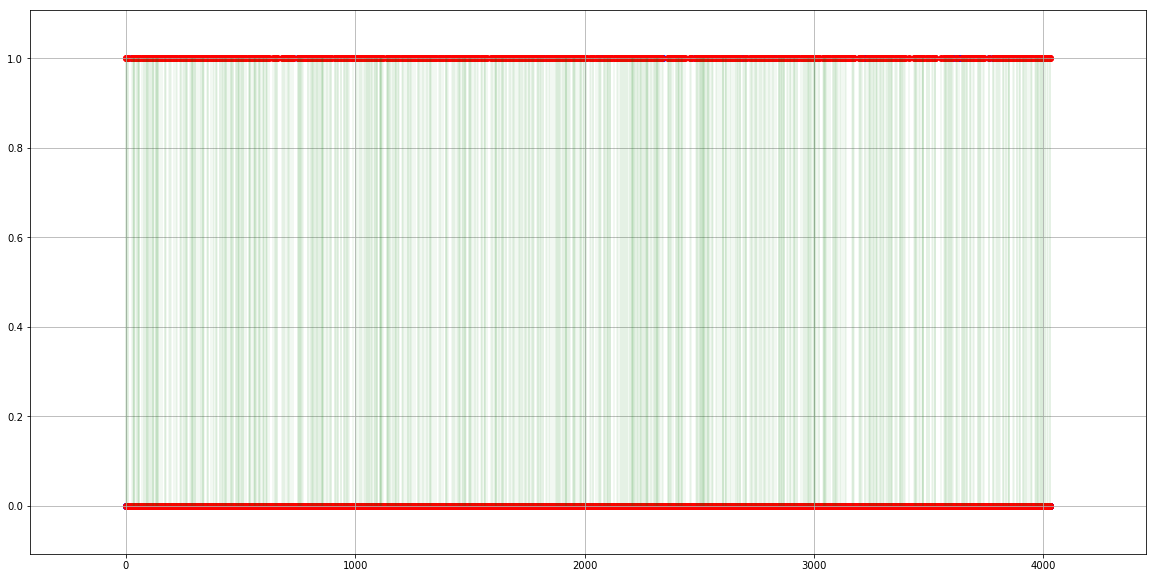

In [122]:
print("Prediction for TEST-SET using best parameters ...")

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print("Combination: [Parameters: " +  str(best_learning_rate) + ", " + str(best_L2_reg) + " | Train model]")
    for step in np.arange(num_steps):
        
                        
        offset = (step * batch_size) % (num_examples - batch_size)
        X_batch = train_dataset[offset:(offset + batch_size), :]
        t_batch = train_labels[offset:(offset + batch_size), :]
        feed_dict = {
            X : X_batch,
            t : t_batch,
            L2_reg : best_L2_reg,
            learning_rate : best_learning_rate
        }
        
        _, l, pred_batch = session.run( [optimizer, loss, train_predictions], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("> Minibatch loss at step %d: %f" % (step, l))
            print("> Training f1: %.1f%%" % score(pred_batch, t_batch))
            print("> Validation f1: %.1f%%" % score(val_predictions.eval(), val_labels))
                
    f1_test = score(test_predictions.eval(), test_labels)
    accuracy_test = accuracy(test_predictions.eval(), test_labels)
    print("|> Test f1: %f%%" % f1_test)
    print("|> Test accuracy: %f%%" % accuracy_test)
    plot_results(test_predictions.eval(), test_labels)